In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 81352554.80it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 69658248.32it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26704654.84it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8041590.87it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolution block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3), # 16,26,26
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3), # 32,24,24
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.10)
        )
        # transition block 1
        self.trans_block1 = nn.Sequential(
            nn.MaxPool2d(2, 2), # 16,12,12 - reduce output
            nn.Conv2d(16, 8, 1), # 8,12,12 - reduce channels
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        # convolution block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3), # 16,10,10
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3), # 64,8,8
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.10)
        )

        # transition block 2
        self.trans_block2 = nn.Sequential(
            nn.MaxPool2d(2, 2),   # 16,4,4 - reduce output
            nn.Conv2d(16, 10, 1), # 10,4,4 - reduce channels
            nn.BatchNorm2d(10),
            nn.ReLU()
        )

        # final block
        self.final_block = nn.Sequential(
            nn.AvgPool2d(kernel_size=4) # 10
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans_block1(x)
        x = self.conv2(x)
        x = self.trans_block2(x)
        x = self.final_block(x)
        x = x.view(-1,10)
        return F.log_softmax(x, dim=-1)

In [6]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           2,320
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
           Dropout-7           [-1, 16, 24, 24]               0
         MaxPool2d-8           [-1, 16, 12, 12]               0
            Conv2d-9            [-1, 8, 12, 12]             136
      BatchNorm2d-10            [-1, 8, 12, 12]              16
             ReLU-11            [-1, 8, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           1,168
      BatchNorm2d-13           [-1, 16, 10, 10]              32
             ReLU-14           [-1, 16,

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.26966091990470886 Batch_id=468 Accuracy=84.62: 100%|██████████| 469/469 [00:17<00:00, 27.30it/s]



Test set: Average loss: 0.4388, Accuracy: 9430/10000 (94.30%)

EPOCH: 1


Loss=0.20926396548748016 Batch_id=468 Accuracy=96.43: 100%|██████████| 469/469 [00:18<00:00, 25.74it/s]



Test set: Average loss: 0.2180, Accuracy: 9679/10000 (96.79%)

EPOCH: 2


Loss=0.1074165478348732 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s]



Test set: Average loss: 0.1754, Accuracy: 9719/10000 (97.19%)

EPOCH: 3


Loss=0.09955430775880814 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:18<00:00, 25.95it/s]



Test set: Average loss: 0.1491, Accuracy: 9710/10000 (97.10%)

EPOCH: 4


Loss=0.15257500112056732 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s]



Test set: Average loss: 0.1304, Accuracy: 9760/10000 (97.60%)

EPOCH: 5


Loss=0.07745622843503952 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:18<00:00, 25.63it/s]



Test set: Average loss: 0.1029, Accuracy: 9824/10000 (98.24%)

EPOCH: 6


Loss=0.11463095992803574 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:17<00:00, 26.29it/s]



Test set: Average loss: 0.1086, Accuracy: 9794/10000 (97.94%)

EPOCH: 7


Loss=0.08787738531827927 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s]



Test set: Average loss: 0.0956, Accuracy: 9806/10000 (98.06%)

EPOCH: 8


Loss=0.04895719885826111 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:17<00:00, 26.21it/s]



Test set: Average loss: 0.0991, Accuracy: 9803/10000 (98.03%)

EPOCH: 9


Loss=0.07031695544719696 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]



Test set: Average loss: 0.0787, Accuracy: 9823/10000 (98.23%)

EPOCH: 10


Loss=0.04098810255527496 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:17<00:00, 27.36it/s]



Test set: Average loss: 0.0777, Accuracy: 9830/10000 (98.30%)

EPOCH: 11


Loss=0.034302737563848495 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]



Test set: Average loss: 0.0743, Accuracy: 9828/10000 (98.28%)

EPOCH: 12


Loss=0.09875184297561646 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:17<00:00, 27.26it/s]



Test set: Average loss: 0.0671, Accuracy: 9852/10000 (98.52%)

EPOCH: 13


Loss=0.027762584388256073 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:16<00:00, 27.80it/s]



Test set: Average loss: 0.0675, Accuracy: 9850/10000 (98.50%)

EPOCH: 14


Loss=0.07085448503494263 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:17<00:00, 26.37it/s]



Test set: Average loss: 0.0674, Accuracy: 9844/10000 (98.44%)



Text(0.5, 1.0, 'Test Accuracy')

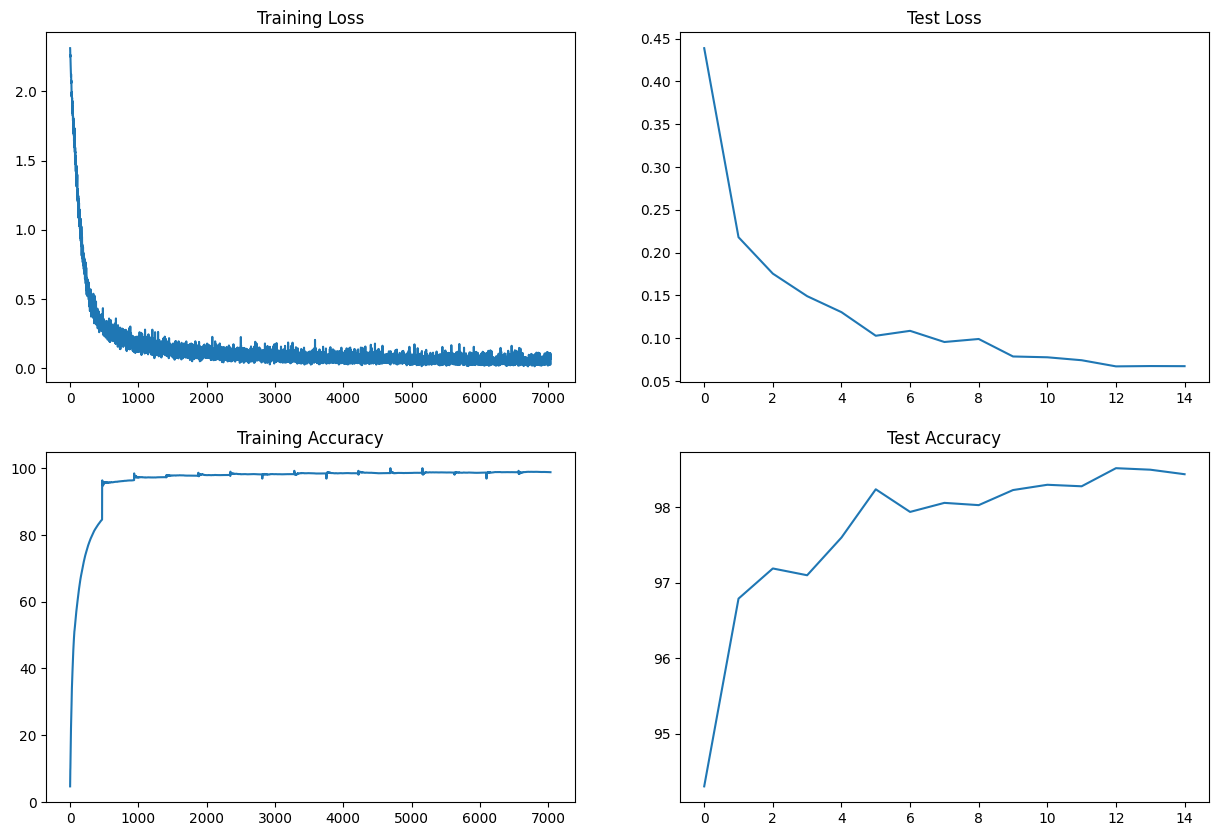

In [9]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")